In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 这一行注释掉就是使用gpu，不注释就是使用cpu

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pyDOE import lhs
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [4]:
class gPINN:
    def __init__(self, ics_data, bcs_data, res_data, layers, activation, lr, weight_g):
        self.ics_data = ics_data
        self.bcs_data = bcs_data
        self.res_data = res_data
        self.lr = lr
        self.activation = activation
        self.weight_g = weight_g
        self.loss_log = []
        self.loss_res_log = []
        self.loss_ics_log = []
        self.loss_bcs_log = []
        # initial neural network
        self.weights, self.biases = self.initilize_NN(layers)
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        # define placeholder
        # initial condition
        self.u_i_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_i_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_i_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        # boundary condition
        self.t_b_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_b_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        # collocation points
        self.t_r_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_r_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        # define u, f, residual loss
        self.u_res   = self.net_u(self.x_r_tf, self.t_r_tf)
        self.f       = self.net_f(self.u_res, self.x_r_tf, self.t_r_tf)
        self.loss_res= tf.reduce_mean(tf.square(self.f))
        # Dirichlet boundary
        self.u_bcs   = self.net_u(self.x_b_tf, self.t_b_tf)
        self.loss_bcs= tf.reduce_mean(tf.square(self.u_bcs))
        self.u_ics   = self.net_u(self.x_i_tf, self.t_i_tf)
        self.loss_ics= tf.reduce_mean(tf.square(self.u_ics - self.u_i_tf))
        # gradient-enhanced
        self.loss_res_deri_x = self.net_f_x(self.f, self.x_r_tf)
        self.loss_res_deri_t = self.net_f_t(self.f, self.t_r_tf)
        # total loss function
        self.loss    = self.loss_res + self.loss_bcs + self.loss_ics + \
                       self.weight_g * self.loss_res_deri_x + \
                       self.weight_g * self.loss_res_deri_t
        # define BFGS optimizer
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(
            self.loss,
            method = 'L-BFGS-B',
            options = {'maxiter': 20000,
                       'maxfun': 50000,
                       'maxcor': 50,
                       'maxls': 50,
                       'ftol' : 1.0 * np.finfo(float).eps}
        )
        init = tf.global_variables_initializer()
        self.sess.run(init)
    '''
    function : initilize_NN
    input    : layers  (list)
    output   : weights ([tf.Variable]), biases ([tf.Variable])
    '''
    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases
    '''
    function : xavier init
    input    : size [layer_in, layer_out]
    output   : W_in_out (tf.Variable)
    '''
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    '''
    function : neural_net
    input    : X -- input of the NN, weights, biases, activation
    output   : Y -- output of the NN
    '''
    def neural_net(self, X, weights, biases, activation):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    '''
    define u
    '''
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases, self.activation)
        return u
    '''
    define f (residual loss)
    '''
    def net_f(self, u, x, t):
        u_t  = tf.gradients(u, t)[0]
        u_x  = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        return u_t + u*u_x - 0.01 / np.pi * u_xx

    def net_f_x(self, res, x):
        res_x = tf.gradients(res, x)[0]
        return tf.reduce_mean(tf.square(res_x))

    def net_f_t(self, res, t):
        res_t = tf.gradients(res, t)[0]
        return tf.reduce_mean(tf.square(res_t))

    def train(self):
        u_i, y_i = self.ics_data.get_batch()
        y_b      = self.bcs_data.get_batch()[1]
        y_r      = self.res_data.get_batch()[1]
        tf_dict = {
            self.x_r_tf : y_r[:, 0][:, None],
            self.t_r_tf : y_r[:, 1][:, None],
            self.x_b_tf : y_b[:, 0][:, None],
            self.t_b_tf : y_b[:, 1][:, None],
            self.x_i_tf : y_i[:, 0][:, None],
            self.t_i_tf : y_i[:, 1][:, None],
            self.u_i_tf : u_i
        }
        self.optimizer.minimize(
            self.sess,
            feed_dict = tf_dict,
            fetches = [self.loss]
            # loss_callback = self.callback
        )

    def callback(self, loss):
        print('Loss:', loss)

    def predict(self, X_star, T_star):
        u_star = self.sess.run(self.u_res, {self.x_r_tf: X_star, self.t_r_tf: T_star})
        return u_star

In [5]:
# generate batch size data
class DataGenerator():
    def __init__(self, u, y, batch_size):
        self.u = u
        self.y = y
        self.batch_size = batch_size

    def get_batch(self):
        N = self.u.shape[0]
        index = np.random.randint(0, N, self.batch_size)
        u_ = self.u[index, :]
        y_ = self.y[index, :]
        return u_, y_

In [6]:
data = scipy.io.loadmat(r"D:\Documents\grade4term1\PDE\数学基础\NN\TF_learn\PINN\appendix\Data\burgers_shock.mat")
t = data['t']
x = data['x']
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

In [7]:
'''
Generate ics data & bcs data
'''
batch_size_ics = 256
batch_size_bcs = 100
# ics
x1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
u1 = Exact[0:1,:].T
ics_data = DataGenerator(u1, x1, batch_size_ics)
# bcs x=-1
x2 = np.hstack((X[:,0:1], T[:,0:1]))
u2 = Exact[:,0:1]
# bcs x=1
x3 = np.hstack((X[:,-1:], T[:,-1:]))
u3 = Exact[:,-1:]
bcs_data = DataGenerator(np.vstack([u2, u3]), np.vstack([x2, x3]), batch_size_bcs)

lb = X_star.min(0)
ub = X_star.max(0)

In [8]:
layers = [2, 32, 32, 32, 32, 32, 1]
activation = tf.tanh
lr = 1e-3
iterations = 20000

In [9]:
# # Plot for loss function
# plt.figure(figsize = (6,5))
# # plt.plot(model.loss_log, lw=2)
# plt.plot(gPINN_model.loss_ics_log, lw=2, label='ics')
# plt.plot(gPINN_model.loss_bcs_log, lw=2, label='bcs')
# plt.plot(gPINN_model.loss_res_log, lw=2, label='res')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.yscale('log')
# plt.legend()
# plt.tight_layout()
# plt.savefig('loss.pdf')
# plt.show()

In [10]:
def train_model(N_f, weight_g):
    batch_size_res = N_f
    X_f_train = lb + (ub-lb)*lhs(2, N_f) # pyODE.lhs 拉丁超立方体抽样
    res_data  = DataGenerator(np.zeros((N_f, 1)), X_f_train, batch_size_res)
    start_time = time.time()
    gPINN_tanh = gPINN(ics_data, bcs_data, res_data, layers, activation, lr, weight_g)
    print("Start training! N_f:%d"%(N_f))
    gPINN_tanh.train()
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    return gPINN_tanh

In [11]:
def compute_error(model):
    u_pred = model.predict(X_star[:, 0][:, None], X_star[:, 1][:, None])
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    print('Error u: %e' % (error_u))
    # U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    # Error = np.abs(Exact - U_pred)
    return error_u

In [5]:
ws = [0.1, 0.01]
N_fs = [1500, 2000, 2500, 3000]

In [ ]:
for i in range(len(ws)):
    errors = []
    for N_f in N_fs:
        model = train_model(N_f, ws[i])
        error = compute_error(model)
        print("N_f:%d, error:%f"%(N_f, error))
        errors.append(error)
    errors = np.array(errors)
    np.save('errors_gPINN_w%d.npy'%(i), errors)

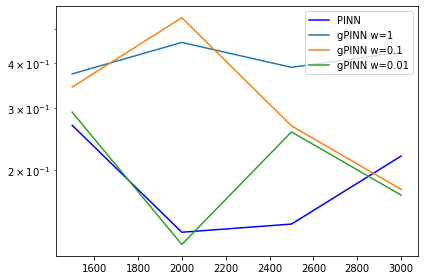

In [10]:
errors_PINN = np.load('errors_PINN.npy')
errors_g_w_1 = np.load('errors_gPINN_w00.npy')
errors_g_w_01 = np.load('errors_gPINN_w01.npy')
errors_g_w_001 = np.load('errors_gPINN_w001.npy')
plt.plot(N_fs, errors_PINN, 'b-', label='PINN')
plt.plot(N_fs, errors_g_w_1, label='gPINN w=1')
plt.plot(N_fs, errors_g_w_01, label='gPINN w=0.1')
plt.plot(N_fs, errors_g_w_001, label='gPINN w=0.01')
plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.savefig('Comparison between NN and gNN L2.pdf')
plt.show()